## Semantic Segmentation 모델로 도로 영역 분리하기  
  
### 데이터셋  
  
### 이미지, 데이터 가져오기
---
도로 영역이 라벨링된 데이터셋을 가지고 있어야 한다. 아래 링크를 통해서 물체 검출(object detection)으로 사용했던 __KITTI 데이터셋의 세그멘테이션 데이터__ 를 다운로드 하자  
  
```
$ mkdir -p ~/aiffel/semantic_segmentation/data
$ wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip
$ unzip data_semantics.zip -d ~/aiffel/semantic_segmentation/data
```
  
![image](https://user-images.githubusercontent.com/63500940/97534118-cc00f580-19fc-11eb-9465-0fcd6e85ec32.png)
![image](https://user-images.githubusercontent.com/63500940/97534125-cefbe600-19fc-11eb-8075-6b4021eb3c87.png)
![image](https://user-images.githubusercontent.com/63500940/97534128-d15e4000-19fc-11eb-8d5f-f3d8d8ce2c89.png)  
  
>Q1. 시맨틱 세그멘테이션의 이미지 라벨의 각 pixel 값은 의미를 갖습니다. 그렇다면 오늘 우리가 시맨틱 세그멘테이션으로 찾아내야 할 도로의 label은  어떤 값일까요? 
공식 홈페이지를 참고하거나 직접 데이터셋을 확인해보셔도 좋습니다.  
예시답 : 7

### 데이터 로더(data loader) 만들기
---
이제 이미지와 데이터셋이 주어졌으니 모델을 학습시킬 수 있는 데이터 로더(data loader)를 만들어보자.  
로더는 입력값 `(224, 224)`, 출력값 `(224, 224)` 크기를 갖는 모델을 학습시킬 수 있도록 데이터셋을 파싱해야한다.  
  
이때 데이터 로더에 __augmentation__ 을 적용해보자. 오늘은 파이썬에서 많이 사용되는  
`albumentations` 를 사용해 볼 것이다. 하지만 Augmentation의 경우 `imgaug` 등 다른 라이브러리 사용이 가능하다.  
  
```python
$ pip install albumentations
```
  
또한 학습셋의 일정량을 __검증 데이터셋(validation dataset)__ 으로 활용할 수 있도록 해야한다.  
  
구현을 할 때 참고할 만한 것  
- <a href="https://hwiyong.tistory.com/241">Keras Sequence에 기반한 Dataloader</a>
- <a href="https://medium.com/the-artificial-impostor/custom-image-augmentation-with-keras-70595b01aeac">Albumentation을 적용한 Keras sequence</a>  
  
만든 후에는 직접 데이터셋이 잘 파싱되어 나오는지 확인해보자.  
데이터셋에 오류가 없어야 성능이 안 나오더라도 문제를 찾기 쉽다.  
  


In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

#### Albumentation 사용법 알아보기
Albumentation의 사용법을 간단히 알아보자.  
Albumentation에서 다양한 augmentatation 기법을 확률적으로 적용할 수 있게 해주는  
`Compose()`의 활용예이다.  
imgaug의 Somtimes()와 유사한 기능이다.

In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
    return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

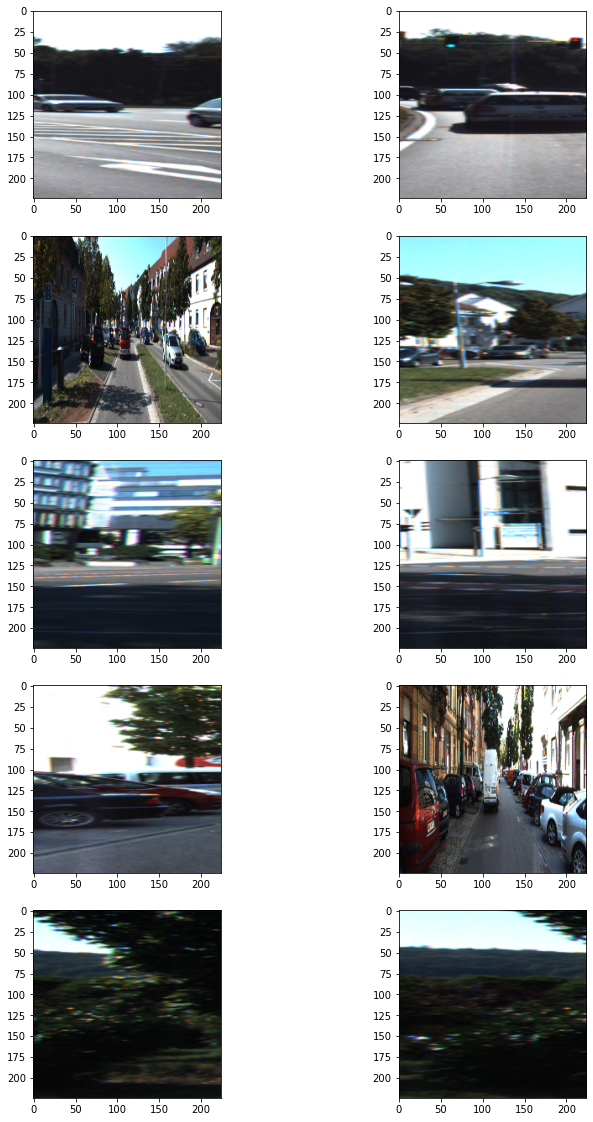

In [3]:
import os

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
plt.show()

이제 데이터셋을 구성해 보자.  
tf.keras.utils.Sequence를 상속받은 generator 형태로 데이터를 구성해 보자.

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self,
                dir_path,
                batch_size=16,
                img_size=(224,224,3),
                output_size=(224,224),
                is_train=True,
                augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size
        
        #load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인한다.
        self.data = self.load_dataset()
        
    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.    
        input_images = glob(os.path.join(self.dir_path, "image_2","*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic","*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [_ for _ in zip(input_images, label_images)]
        
        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data)/self.batch_size)
    
    def __getitem__(self, index):
    #입력과 출력을 만든다.
    #입력은 resize 및 augmentation이 적용된 input image이고
    #출력은 semantic label이다.
        batch_data = self.data[
            index*self.batch_size: (index+1)*self.batch_size
        ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
    
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data={
                "image":_input,
                "mask":_output,
            }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
        return inputs, outputs
    
    def on_epoch_end(self):
    # 한 epoch이 끝나면 실행되는 함수이다. 학습중인 경우에 순서를 random shuffle하도록 적용하는 것을 볼 수 있다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True:
            np.random.shuffle(self.indexes)
            return self.indexes


In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)

train_generator = KittiGenerator(dir_path,
                                augmentation=augmentation,)
test_generator = KittiGenerator(dir_path,
                               augmentation=test_preproc,
                               is_train = False)

### 시맨틱 세그멘테이션 모델  
  
![image](https://user-images.githubusercontent.com/63500940/97538034-14bbad00-1a03-11eb-903e-2d1d9aa7cd89.png)  
  
### 모델 구조 만들기
---
비교적 단순한 U-Net을 구현해 보자.

In [8]:
def build_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)

    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(drop5)) 
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    up9 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

### 모델 학습하기
---

In [15]:
def bce_dice_loss():
    def f_score(gt, pr, class_weights=1, beta=1, smooth=1, per_image=True, threshold=None):
        if per_image:
            axes = [1, 2]
        else:
            axes = [0, 1, 2]
        if threshold is not None:
            pr = tf.keras.backend.greater(pr, threshold)
            pr = tf.keras.backend.cast(pr, K.floatx())
        tp = tf.keras.backend.sum(gt * pr, axis=axes)
        fp = tf.keras.backend.sum(pr, axis=axes) - tp
        fn = tf.keras.backend.sum(gt, axis=axes) - tp
        score = ((1 + beta ** 2) * tp + smooth) \
                / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + smooth)
        # mean per image
        if per_image:
            score = tf.keras.backend.mean(score, axis=0)
        # weighted mean per class
        score = tf.keras.backend.mean(score * class_weights)
        return score
    def dice_loss(gt, pr, class_weights=1., smooth=1, per_image=True, beta=1.):
        return 1 - f_score(gt, pr, class_weights=class_weights, smooth=smooth, per_image=per_image, beta=beta)
    def bce_dice(gt, pr, bce_weight=1., smooth=1, per_image=True, beta=1.):
        bce = tf.keras.backend.mean(tf.keras.losses.binary_crossentropy(gt, pr))
        loss = bce_weight * bce + dice_loss(gt, pr, smooth=smooth, per_image=per_image, beta=beta)
        return loss
    return bce_dice

In [16]:
model = build_model()
model.compile(optimizer = Adam(lr = 1e-4), loss = bce_dice_loss())
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=50,
 )

model_path = dir_path + '/seg_model_unet.h5'
model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/50
11/11 [==============================] - 7s 611ms/step - loss: 1.2838 - val_loss: 1.1041
Epoch 2/50
11/11 [==============================] - 6s 582ms/step - loss: 0.9941 - val_loss: 0.9189
Epoch 3/50
11/11 [==============================] - 7s 628ms/step - loss: 0.9165 - val_loss: 0.8699
Epoch 4/50
11/11 [==============================] - 7s 638ms/step - loss: 0.8569 - val_loss: 0.8421
Epoch 5/50
11/11 [==============================] - 7s 606ms/step - loss: 0.8518 - val_loss: 0.8053
Epoch 6/50
11/11 [==============================] - 6s 588ms/step - loss: 0.8121 - val_loss: 0.7666
Epoch 7/50
11/11 [==============================] - 7s 659ms/step - loss: 0.8085 - val_loss: 0.7459
Epoch 8/50
11/11 [==============================] - 7s 665ms/step - loss: 0.8595 - val_loss: 0.9383
Epoch 9/50
11/11 [==============================] - 6s 590ms/step - loss: 0.8415 - val_loss: 0.7801
Epoch 10/50
11/11 [==============================] - 7s 605ms/step - loss: 0.7766 - val_loss: 0.7642

### 시맨틱 세그멘테이션 모델 시각화
이번에는 학습한 모델의 결과를 눈으로 확인해볼 차례입니다. 테스트 셋은 이미지를 제공하지만 정답 데이터를 제공하지 않으니 눈으로 확인할 수 있도록 모델이 추론(inference)한 결과를 우리의 눈으로 볼 수 있는 세그멘테이션 이미지로 만들어주세요!  

이때 입력 이미지와 라벨을 한번에 볼 수 있도록 모델의 출력값을 입력 이미지 위에 겹쳐서 보이기, 즉 오버레이(overray) 해 주세요. PIL 패키지를 사용하신다면 Image.blend를 활용하실 수 있습니다.  

(참고) 이전 스텝에서 저장된 모델은 이후 아래와 같이 로드해서 활용할 수 있습니다.

In [17]:
model = tf.keras.models.load_model(model_path)

ValueError: Unknown loss function: bce_dice

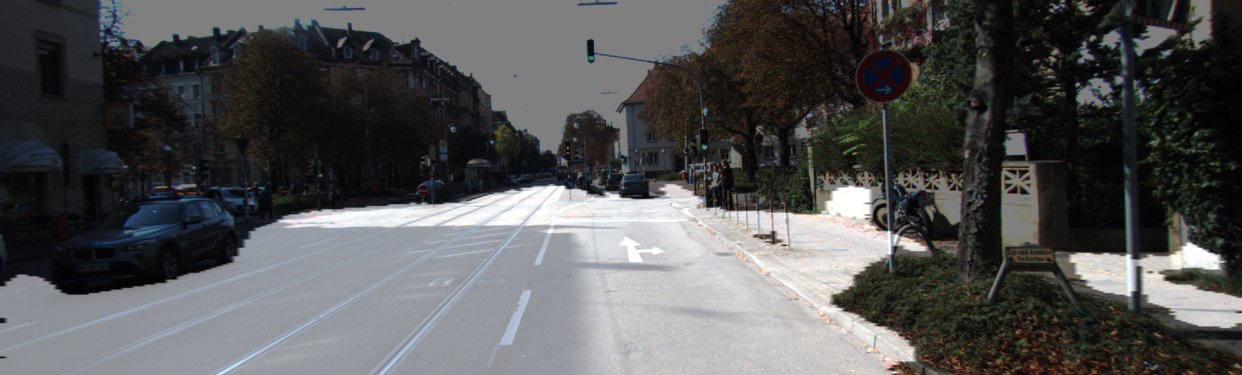

In [18]:
def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output

# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

세그멘테이션이 성능을 정량적으로 측정하기 위한 방법으로 IoU(Intersection over Union)를 계산하게 됩니다. IoU를 계산하는 방법은 지난 시간에 소개한 바 있으므로 해당 내용을 활용하여 구현해 보겠습니다.  
  
IoU를 계산하려면 모델이 `도로 영역`이라고 `판단`한 부분이 `1`로, 나머지 부분이 `0`으로 표시된 행렬, 그리고 `라벨 데이터`에서 `도로 영역`이 `1`, 나머지 부분이 `0`으로 표시된 행렬이 필요합니다. 각각을 `prediction`, `target`이라고 불렀을 때 이를 계산하는 함수를 구현해 보겠습니다. 위에 구현했던 `get_output`을 좀더 확장해서 `output`, `prediction`, `target`을 함께 리턴하도록 구현해 봅시다.

In [19]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [20]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [21]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.812884


0.8128842380640942

### 프로젝트 : 개선된 U-Net 모델 만들기
  
U-Net을 통한 시맨틱 세그멘테이션 결과가 충분히 만족스러우신가요? 어느정도 동작하는 것 같긴 하지만 좀더 개선할 여지도 보일 것입니다.  
  
2018년에 U-Net++라는 논문이 나왔습니다. 이 논문은 기존에 아주 단순하면서도 세그멘테이션에서 효과를 발휘했던 U-Net의 네트워크 구조에 DenseNet의 아이디어를 가미하여 성능을 개선한 모델입니다.  
  
그래서 모델의 구조 자체는 아래 그림에서 보는 것처럼 별다른 설명이 없이도 직관적으로 이해가 가능한 수준입니다. 오늘 소개되었던 U-Net의 모델 코드를 조금만 수정 확장하면 충분히 구현할 수 있을 것입니다. 그래서 오늘의 과제는 바로 U-Net++ 모델을 스스로의 힘으로 직접 구현해 보고, U-Net을 활용했던 도로 세그멘테이션 태스크에 적용하여 U-Net을 썼을 때보다 성능이 향상되었음을 확인해 보는 것입니다. 정성적으로는 두 모델의 세그멘테이션 결과를 시각화해서 비교해 볼 수 있을 것이고, 정량적으로는 동일 이미지에 대한 IoU값을 비교해 보면 될 것입니다.

- (참고) <a href="https://sh-tsang.medium.com/review-unet-a-nested-u-net-architecture-biomedical-image-segmentation-57be56859b20">U-Net++ 저자 블로그</a>  
  
![image](https://user-images.githubusercontent.com/63500940/97539786-ea1f2380-1a05-11eb-9191-310e4958aca3.png)